### Most minority variants are not reproducible across sequencing replicates.

In [1]:
#load packages
library(ggplot2)
library(plyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(glue)
library(cowplot)
library(UpSetR)
library(pheatmap)
library(vcfR)
library(igraph)
library(ggpubr)
library(readr)
library(VennDiagram)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # 

In [2]:
# set working folders
#project_folder <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-SNV'
#mva_folder <- glue("{project_folder}/compare_callers/202204")
#output_folder <- glue("{mva_folder}/062322_output")
#code <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/code/SARS-CoV-2_analysis'

project_folder = '/home/kate/Lab/MAF/scripts/GITHUB/Optimized-Quantification-of-Intrahost-Viral-Diversity'
mva_folder ='/home/kate/Lab/MAF/scripts/GITHUB/Optimized-Quantification-of-Intrahost-Viral-Diversity/clinical_data_files'
output_folder = '/home/kate/Lab/MAF/scripts/GITHUB/Optimized-Quantification-of-Intrahost-Viral-Diversity'
code = '/home/kate/Lab/MAF/scripts/GITHUB/Optimized-Quantification-of-Intrahost-Viral-Diversity/analysis_code'

In [3]:
# source scripts
source(glue("{code}/cov_aalist.R"))
source(glue("{code}/repsnv.R"))
source(glue("{code}/snv_filter.R"))
source(glue("{code}/vennsD.R"))
source(glue("{code}/common.R"))
source(glue("{code}/aasnplist_load.R"))
source(glue("{code}/getminorvariants.R"))
source(glue("{code}/cov_aalist.R"))

In [4]:
# set color palettes
tool_colors <- c('#CC2F42', # freebayes - red
                 '#35B6E9', # hc - bright blue
                 '#009E73', # ivar - green
                 '#F9BECD', # lofreq - pink
                 '#F0E442', # mutect2 - yellow
                 '#CCD2EB', # timo - light purple
                 '#8DA1E2', # timo-no-binom - darker purple
                 '#9B9E9A', # varscan - grey
                 '#555555') # varscan, custom1 - darker grey
cat_colors <- c('#2F142B', # TP - dark purple
                '#F2A07B', # FP - peach
                '#5A7A96') # FN - blue
cov_af_colors <- c('#DDDDDD', # 100X - lightest grey
                '#BBBBBB', # 200X
                '#999999', # 300X
                '#777777', # 500X
                '#555555', # 1000X
                '#333333', # 10000X
                '#111111') # 100000X - darkest grey
virus_colors <- c('#2F142B', # H1N1 - dark purple
                  '#F2A07B', # H3N2 - peach
                  '#43668B', # VICT - blue
                  '#8DA1E2') # SARS - light purple

In [5]:
SEGMENTS = c('SARS-CoV2')
# Here we set the coverage cutoff to 5 for identification of consensus changes and the coverage cutoff to 200 for
# identification of minority variants
covcutoff = 5
minorcov = 200
# The initial allele frequency is set to .5%
minfreq = 0.01
# we exclude any instances were an 'N' is called in these analyses
ntlist = c('A','G','T','C')
orf1 <- c('nsp1','nsp2','nsp3','nsp4','nsp5',
          'nsp6','nsp7','nsp8','nsp9','nsp10',
          'nsp11','nsp12a','nsp12b','nsp13',
          'nsp14','nsp15','nsp16')

In [6]:
# load in metadata for samples with high coverage - used for this analysis
highcov <- read.csv(glue("{mva_folder}/highcov.samples.csv"))

We used each of the seven variant calling tools that were tested on the simulated and synthetic data to identify minority variants in these samples

In [7]:
# load in VCF files for all samples - generated with vcf_load notebook
#vcf.all <- read.csv(file = glue("{project_folder}/compare.callers.vcfs.csv"))

vcf.all = rbind(read.csv(file = glue("{mva_folder}/freebayes.variants.csv"), header = TRUE),
                read.csv(file = glue("{mva_folder}/haplotypecaller.variants.csv"), header = TRUE),
                read.csv(file = glue("{mva_folder}/ivar.variants.csv"), header = TRUE),
                read.csv(file = glue("{mva_folder}/lofreq.variants.csv"), header = TRUE),
                read.csv(file = glue("{mva_folder}/mutect2.variants.csv"), header = TRUE),
                read.csv(file = glue("{mva_folder}/timo.variants.csv"), header = TRUE),
                read.csv(file = glue("{mva_folder}/varscan.variants.csv"), header = TRUE))


and filtered them using a read depth cutoff of 200 and an allele frequency cutoff of 0.01, based on the cutoffs determined in our simulated and synthetic data

In [8]:
# extract minor changes
# fill data frame with all changes with variant frequency > 3% and less than 50%
covcutoff = 200
afcutoff = 0.01

min.changes <- vcf.all %>% filter(refnt %in% ntlist &
                                  varnt %in% ntlist &
                                  varfreq >= afcutoff &
                                  varfreq < 0.5 &
                                  param == 'standard' &
                                  !tool == 'freebayes' &
                                  totalcount >= covcutoff)

min.changes.fb <- vcf.all %>% filter(refnt %in% ntlist &
                                  varnt %in% ntlist &
                                  varfreq >= afcutoff &
                                  varfreq < 0.5 &
                                  param == 'custom' &
                                  tool == 'freebayes' &
                                  totalcount >= covcutoff)

min.changes <- rbind(min.changes, min.changes.fb)

min.changes$change <- paste0(min.changes$refnt,min.changes$ntpos,min.changes$varnt)
min.changes$sample.change <- paste0(min.changes$source_ID,":",min.changes$change)
min.changes$rep.change <- paste0(min.changes$rep,"-",min.changes$sample.change)

min.changes <- distinct(min.changes)

In [9]:
# extract minor changes
# fill data frame with all changes with variant frequency > 3% and less than 50%
covcutoff = 200
afcutoff = 0.01

min.changes.high <- min.changes %>% filter(source_ID %in% highcov$code)

min.list.1.high <- list()
# fill min.list with lists of the high confidence majority variants called by each tool
temp1 <- min.changes.high %>% filter(rep == 'REP1')
for(caller in unique(temp1$tool)) {
    temp <- temp1 %>%
        filter(tool == caller)
    min.list.1.high[[caller]] <- c(min.list.1.high[[caller]],temp$sample.change)
}

min.list.2.high <- list()
# fill min.list with lists of the high confidence minority variants called by each tool
temp2 <- min.changes.high %>% filter(rep == 'REP2')
for(caller in unique(temp2$tool)) {
    temp <- temp2 %>%
        filter(tool == caller)
    min.list.2.high[[caller]] <- c(min.list.2.high[[caller]],temp$sample.change)
}

names(min.list.1.high) <- c('hc-1','ivar-1','timo-1','mutect2-1','varscan-1','lofreq-1','freebayes-1')
names(min.list.2.high) <- c('hc-2','ivar-2','timo-2','mutect2-2','varscan-2','lofreq-2','freebayes-2')

rm(temp, temp1, temp2)

# alphabetize the names in the list for easier plotting
min.list.1.high <- min.list.1.high[order(names(min.list.1.high), decreasing = TRUE)]
min.list.2.high <- min.list.2.high[order(names(min.list.2.high), decreasing = TRUE)]

 In our sequencing data, the number of variants identified in each replicate by each tool was markedly different, suggesting that many of the identified minor variants may not be true variants introduced through viral replication, but instead variants introduced during PCR or sequencing (Fig. 4A, S8A-B). As was shown with our simulated and synthetic data, errors introduced through PCR, library preparation, and sequencing are mostly random, and therefore less likely to reappear in multiple sequencing replicates (Fig. 3). In order to find high confidence minority variants, we looked at the intersection of variants between the two replicates using each caller and plotted this against the total variants identified in each replicate (Fig. 5A).

In [10]:
ivar <- min.changes.high %>% filter(tool == 'ivar')

ivar_list <- list()
    
for(replicate in unique(ivar$rep)) {
    temp <- ivar %>%
        filter(rep == replicate)
    ivar_list[[replicate]] <- c(ivar_list[[replicate]],temp$sample.change)
}

names(ivar_list) <- c("ivar-rep1","ivar-rep2")

In [11]:
mutect <- min.changes.high %>% filter(tool == 'mutect2')

mutect_list <- list()
    
for(replicate in unique(mutect$rep)) {
    temp <- mutect %>%
        filter(rep == replicate)
    mutect_list[[replicate]] <- c(mutect_list[[replicate]],temp$sample.change)
}

names(mutect_list) <- c("mutect-rep1","mutect-rep2")

In [12]:
varscan <- min.changes.high %>% filter(tool == 'varscan')

varscan_list <- list()
    
for(replicate in unique(varscan$rep)) {
    temp <- varscan %>%
        filter(rep == replicate)
    varscan_list[[replicate]] <- c(varscan_list[[replicate]],temp$sample.change)
}

names(varscan_list) <- c("varscan-rep1","varscan-rep2")

In [13]:
fs <- min.changes.high %>% filter(tool == 'haplotypecaller')

fs_list <- list()
    
for(replicate in unique(fs$rep)) {
    temp <- fs %>%
        filter(rep == replicate)
    fs_list[[replicate]] <- c(fs_list[[replicate]],temp$sample.change)
}

names(fs_list) <- c("fs-rep1","fs-rep2")

In [14]:
timo <- min.changes.high %>% filter(tool == 'timo')

timo_list <- list()
    
for(replicate in unique(timo$rep)) {
    temp <- timo %>%
        filter(rep == replicate)
    timo_list[[replicate]] <- c(timo_list[[replicate]],temp$sample.change)
} 

names(timo_list) <- c("timo-rep1","timo-rep2")

In [15]:
fb <- min.changes.high %>% filter(tool == 'freebayes')

fb_list <- list()
    
for(replicate in unique(fb$rep)) {
    temp <- fb %>%
        filter(rep == replicate)
    fb_list[[replicate]] <- c(fb_list[[replicate]],temp$sample.change)
} 

names(fb_list) <- c("fb-rep1","fb-rep2")

In [16]:
lofreq <- min.changes.high %>% filter(tool == 'lofreq')

lofreq_list <- list()
    
for(replicate in unique(lofreq$rep)) {
    temp <- lofreq %>%
        filter(rep == replicate)
    lofreq_list[[replicate]] <- c(lofreq_list[[replicate]],temp$sample.change)
} 

names(lofreq_list) <- c("lofreq-rep1","lofreq-rep2")

The number of reproducible variants varied greatly between callers. Ivar and freebayes called the highest number of reproducible variants, while timo called the fewest, but the highest percentage of reproducible minor variants. Timo is one of the most conservative callers that was tested; however, these data indicate that being conservative may lead to increased reproducibility. It is however important to note that the relatively low percentages of reproducible variants are likely skewed by the high numbers of low frequency variants found in replicate 2 (Fig. 5A, S8A).

In [22]:
#caller.lists <- list(fb_list, fs_list, ivar_list, lofreq_list, mutect_list, timo_list, varscan_list)
#cr_list <- list(fb_list, fs_list, ivar_list, lofreq_list, mutect_list, timo_list, varscan_list)

cr_list = list(fb_list, fs_list, ivar_list, lofreq_list, mutect_list, timo_list, varscan_list)
#cr_list <- list(varscan_list, timo_list, ivar_list, fb_list)

In [23]:
repro <- data.frame()

for(i in cr_list) {
    both <- get.venn.partitions(i)[1,5]
    rep1 <- get.venn.partitions(i)[3,5] + get.venn.partitions(i)[1,5]
    rep2 <- get.venn.partitions(i)[2,5] + get.venn.partitions(i)[1,5]
    name <- names(get.venn.partitions(i))[1]
    
    repro <- rbind(repro, c(name, both, rep1, rep2))
}
names(repro) <- c("caller","both","rep1","rep2")
repro$caller <- gsub("-rep1","",repro$caller)

repro$both <- as.numeric(repro$both)
repro$rep1 <- as.numeric(repro$rep1)
repro$rep2 <- as.numeric(repro$rep2)

repro <- repro %>% mutate(percent = (both/(rep1+rep2))*100)

repro <- melt(repro)
repro$value <- round(repro$value, 2)

Using caller as id variables



### Fig. 5A

In [29]:
head(subset(repro, variable == 'percent'))

,caller,variable,value
,<chr>,<fct>,<dbl>
22,fb,percent,11.25
23,fs,percent,8.49
24,ivar,percent,16.50
25,lofreq,percent,9.95
26,mutect,percent,11.82
27,timo,percent,18.45


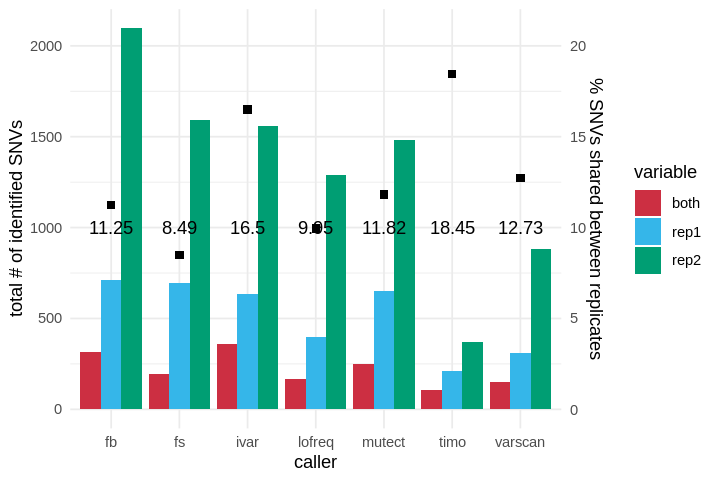

In [33]:
options(repr.plot.width=6, repr.plot.height=4)
num_plot <- ggplot() +

    geom_col(data = subset(repro, !variable == 'percent'),
                           aes(x = caller, y = value, fill = variable), position = 'dodge') +

    geom_point(data = subset(repro, variable == 'percent'),
              aes(x= caller, y = value*100), color = 'black', size = 2, shape = 15) +
    geom_text(data = subset(repro, variable == 'percent'),
              aes(x = caller, y = 1000, label = value)) +

    theme_minimal() +
    
    scale_y_continuous(
    
        # Features of the first axis
        name = "total # of identified SNVs",
    
        # Add a second axis and specify its features
        sec.axis = sec_axis( trans=~./100, 
                            name="% SNVs shared between replicates")) +

    scale_fill_manual(values = tool_colors[c(1:6,8)])
             

print(num_plot)

In [34]:
ggsave(num_plot, filename = "repvarpercaller.pdf",
    path=output_folder, width = 6, height = 4, limitsize=FALSE, useDingbats =FALSE)

We then looked at the intersection of just the variants found by each tool in both replicates. Only 80 SNVs were found by all variant callers across replicates, while 382 SNVs were found to be reproducible across replicates by at least one tool (Fig. 5B). 

In [21]:
overlaps <- c(get.venn.partitions(cr_list[c(7:8)])[1,4],
              get.venn.partitions(cr_list[c(5:6)])[1,4],
              get.venn.partitions(cr_list[c(1:2)])[1,4],
              get.venn.partitions(cr_list[c(11:12)])[1,4]
              )
#caller.lists
names(overlaps) <- c("varscan","timo","ivar","freebayes")

Warning message in get.venn.partitions(cr_list[c(7:8)]):
“removing NULL elements in list.”
Warning message in make.truth.table(x):
“fixing missing, empty or duplicated names.”


ERROR: Error in array(x, c(length(x), 1L), if (!is.null(names(x))) list(names(x), : 'data' must be of a vector type, was 'NULL'


In [ ]:
# Plot intersections of minority variants in rep2 between all callers
pdf(file = glue("{output_folder}/upset.sharedvars.pdf"),   # The directory you want to save the file in
    width = 5, # The width of the plot in inches
    height = 4) # The height of the plot in inches

upset(fromList(overlaps), 
      sets = names(overlaps), 
      point.size = 2, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.2, 
      keep.order=TRUE,
      order.by='degree')

dev.off()

### Fig. 5B

In [ ]:
options(repr.plot.width=8, repr.plot.height=8)

upset(fromList(overlaps), 
      sets = names(overlaps), 
      point.size = 3, 
      line.size = 1, 
      mainbar.y.label = "MV intersections", 
      sets.x.label = "MVs identified per caller", 
      text.scale = 1.8, 
      keep.order=TRUE,
      order.by='degree')

Together, these data suggest that most minority variants are not reproducible across replicates and support the idea that perhaps more than any other criteria, sequencing replicate has the highest impact on the set of minority variants identified (Fig. 5B, S8B).

### Variants identified by all variant callers show the most reproducible frequencies.

Using synthetic data, we showed that in a controlled setting, SNVs that were found in both sequencing replicates generally showed reproducible frequencies. Given that frequency is an important metric in most analyses performed using minority variant data, we wanted to test if this held true in clinical samples.

In [ ]:
shared <- min.changes.high %>% group_by(sample.change) %>% tally()
min.changes.high <- merge(min.changes.high, shared, by = ("sample.change"), all.x=T, all.y = T)

In [ ]:
rep1 <- min.changes.high %>% filter(rep == 'REP1')
rep2 <- min.changes.high %>% filter(rep == 'REP2')

names(rep1)[names(rep1) == 'varfreq'] <- "varfreq.rep1"
names(rep2)[names(rep2) == 'varfreq'] <- "varfreq.rep2"
names(rep1)[names(rep1) == 'totalcount'] <- "dp.rep1"
names(rep2)[names(rep2) == 'totalcount'] <- "dp.rep2"
replicates <- merge(rep1, rep2,
                    by=c("source_ID","tool","ntpos","change","refnt","varnt","n"),
                    all.x = T, all.y = T) %>% 
              select(-c(rep.x,rep.y))
replicates[is.na(replicates)] <- 0

In [ ]:
cell_colors = colorRampPalette(c("#BCBCBC", "#E76F51"))(14)

Plotting the frequency in replicate 1 against the frequency in replicate 2 revealed that while some variants showed consistent frequencies, some differed very drastically – identified at 5-10% in one replicate and as high as 45-50% in the other replicate (Fig. 5C). These data were striking as they reveal that averaging frequency across replicates, or performing only one sequencing replicate, could drastically alter downstream analyses performed using these numbers.

Interestingly, when we looked at the variants that were reproducible across replicates and found by most or all of the variant callers, frequency tended to be much more consistent than those identified only in a single replicate, or by a single caller (Fig. 5C, dark red points).

### Fig. 5C

In [ ]:
# adjusted by kate, 12.2.2022
options(repr.plot.width=12, repr.plot.height=2)
plot21 = replicates %>%

    ggplot(aes(x=varfreq.rep1, y=varfreq.rep2, color=n)) +

        geom_point(size=2, alpha=0.7, shape='square') +

        facet_grid(~tool) +

        scale_x_continuous(name = "rep1",
                           limits=c(0,0.5)) +
    
        scale_y_continuous(name = "rep2",
                           limits=c(0,0.5)) +
        
        theme_bw() +
        geom_abline(linetype = 2) + 
        labs(x='replicate 1', y='replicate 2') + 
        scale_color_gradient2(low = "#8a8584", mid = "#edac9f", high = "#db390f", midpoint = 7)

print(plot21)

In [ ]:
plot21c = replicates %>%
    filter(varfreq.rep1 <= 0.10 & varfreq.rep2 <= 0.10) %>% 

    ggplot(aes(x=varfreq.rep1, y=varfreq.rep2, color=n)) +

        geom_point(size=2, alpha=0.7, shape='square') +

        facet_grid(~tool) +
        xlim(0, 0.10) + 
        ylim(0, 0.10) + 
        
        #scale_x_continuous(name = "rep1",
        #                   limits=c(0,0.5)) +
    
        #scale_y_continuous(name = "rep2",
        #                   limits=c(0,0.5)) +
        
        theme_bw() +
        geom_abline(linetype = 2) + 
        labs(x='replicate 1', y='replicate 2') + 
        scale_color_gradient2(low = "#8a8584", mid = "#edac9f", high = "#db390f", midpoint = 7)

print(plot21c)

In [ ]:
ggsave(plot21, filename = "rep.frequency.pdf",
    path=output_folder, width = 12, height = 2.5, limitsize=FALSE, useDingbats =FALSE)
ggsave(plot21c, filename = "rep.frequency.inset.pdf",
    path=output_folder, width = 12, height = 2.5, limitsize=FALSE, useDingbats =FALSE)

In [ ]:
# only plot 1% to 10% and only variants with high reproducibility to show zoom slightly better
options(repr.plot.width=12, repr.plot.height=2)
plot21b = replicates %>% filter(n > 10) %>%

    ggplot(aes(x=varfreq.rep1, y=varfreq.rep2, color=n)) +

        geom_point(size=2, alpha=0.7, shape='square') +

        facet_grid(~tool) +

        scale_x_continuous(name = "rep1",
                           limits=c(0,0.1)) +
    
        scale_y_continuous(name = "rep2",
                           limits=c(0,0.1)) +
        
        theme_bw() +

        scale_color_gradient2(low = "#8a8584", mid = "#edac9f", high = "#db390f", midpoint = 12)

print(plot21b)

Together, these data suggest that variant identification is complicated, but that certainty in each variant and its frequency is increased with replicate sequencing and identification by many variant callers.

We wanted to investigate if there was a frequency cutoff that optimized the number of variants matching the set of reproducible variants called by multiple callers. To do this, we looked at the intersection of SNVs called in both replicates, by the four callers that performed the best on the synthetic and simulated datasets, and compared those to the intersection of SNVs called by the same four callers in each individual replicate.

In [ ]:
freq.list <- c(0.1, 0.05, 0.04, 0.03, 0.02, 0.01)

In [ ]:
both.changes <- min.changes.high %>% filter(sample.change %in% unlist(get.venn.partitions(overlaps)[1,6])) %>% select(sample.change, ntpos, source_ID, refnt, varnt, change) %>% distinct()
both.changes$type <- 'both'
both.changes$overlap <- 'both'

tpfp.af <- data.frame()

for(af in freq.list) {
    
    r1.changes <- min.changes.high %>% filter(varfreq > af & sample.change %in% unlist(get.venn.partitions(min.list.1.high[c(1,2,5,7)])[1,6])) %>% select(sample.change, ntpos, source_ID, refnt, varnt, change) %>% distinct()
    r1.changes$type <- 'r1'
    r1.changes <- r1.changes %>% mutate(overlap = ifelse(sample.change %in% both.changes$sample.change, "both","rep1"))
    
    r2.changes <- min.changes.high %>% filter(varfreq > af & sample.change %in% unlist(get.venn.partitions(min.list.2.high[c(1,2,5,7)])[1,6])) %>% select(sample.change, ntpos, source_ID, refnt, varnt, change) %>% distinct()
    r2.changes$type <- 'r2'
    r2.changes <- r2.changes %>% mutate(overlap = ifelse(sample.change %in% both.changes$sample.change, "both","rep2"))
    
    compare.changes <- do.call('rbind', list(r1.changes, r2.changes))
    
    tpfp <- compare.changes %>% group_by(type, overlap) %>% tally()
    tpfp$allele_freq <- af
    
    tpfp.af <- rbind(tpfp.af, tpfp)
    
}

We then applied allele frequency cutoffs between 0.01 and 0.1 to determine the best cutoff for use on single replicate data. Here, we identify a true positive as a variant present in the reproducible set, and a false positive as any other variant found in a single replicate. As was noted previously, we find that replicate 2 data shows an increased number of SNVs, perhaps due to freeze/thawing of samples between preparations (Fig. S8A, 5D). As such, we believe that replicate 1 is better representative of what most single replicate data may look like. We found that at an allele frequency cutoff of 0.01, all true positives were found, but the number of false positives was very high, while a frequency cutoff of 0.05 or 0.1 removed too many true positives from the dataset (Fig. 5D).

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
TPR = ggplot() +

    geom_point(data = subset(tpfp.af, overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 2, alpha = 0.8, position=position_dodge(width=0.002)) +

    geom_line(data = subset(tpfp.af, overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 1, position=position_dodge(width=0.002)) +

    theme_bw() +

    scale_y_continuous(name = "# of TP found") +

    scale_x_continuous(name = "AF cutoff",
                       breaks=seq(0,0.10,0.02)) +

    scale_color_manual(values = cat_colors[c(1,3)])

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
FPR = ggplot() +

    geom_point(data = subset(tpfp.af, !overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 2, alpha = 0.8) +

    geom_line(data = subset(tpfp.af, !overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 1) +

    theme_bw() +

    scale_y_continuous(name = "# of 'FP' found") +

    scale_x_continuous(name = "AF cutoff",
                       breaks=seq(0,0.10,0.02)) +

    scale_color_manual(values = cat_colors[c(1,3)])

### Fig. 5D

In [ ]:
options(repr.plot.width=8, repr.plot.height=4)
ggarrange(TPR, FPR, nrow = 1, ncol = 2)

Based on these data, we suggest an allele frequency cutoff of 0.03 when only single replicate data is available, a cutoff that was also confirmed in the simulated and synthetic data sets.

In [ ]:
ggsave(TPR, filename = "tpr.alloverlaps.pdf",
    path=output_folder, width = 3, height = 3, limitsize=FALSE, useDingbats =FALSE)
ggsave(FPR, filename = "fpr.alloverlaps.pdf",
    path=output_folder, width = 3, height = 3, limitsize=FALSE, useDingbats =FALSE)

We further suggest using the intersection of multiple variant callers to increase confidence in the data.

In [ ]:
both.changes <- min.changes.high %>% filter(sample.change %in% unlist(get.venn.partitions(overlaps[c(2,3)])[1,4])) %>% select(sample.change, ntpos, source_ID, refnt, varnt, change) %>% distinct()
both.changes$type <- 'both'
both.changes$overlap <- 'both'

tpfp.af <- data.frame()

for(af in freq.list) {
    
    r1.changes <- min.changes.high %>% filter(varfreq > af & sample.change %in% unlist(get.venn.partitions(min.list.1.high[c(2,5)])[1,4])) %>% select(sample.change, ntpos, source_ID, refnt, varnt, change) %>% distinct()
    r1.changes$type <- 'r1'
    r1.changes <- r1.changes %>% mutate(overlap = ifelse(sample.change %in% both.changes$sample.change, "both","rep1"))
    
    r2.changes <- min.changes.high %>% filter(varfreq > af & sample.change %in% unlist(get.venn.partitions(min.list.2.high[c(2,5)])[1,4])) %>% select(sample.change, ntpos, source_ID, refnt, varnt, change) %>% distinct()
    r2.changes$type <- 'r2'
    r2.changes <- r2.changes %>% mutate(overlap = ifelse(sample.change %in% both.changes$sample.change, "both","rep2"))
    
    compare.changes <- do.call('rbind', list(r1.changes, r2.changes))
    
    tpfp <- compare.changes %>% group_by(type, overlap) %>% tally()
    tpfp$allele_freq <- af
    
    tpfp.af <- rbind(tpfp.af, tpfp)
    
}

When using just the intersection of a high performing, less conservative caller, iVar, and a high performing, more conservative caller, timo, we find a similar trade-off in true positive and false positive data when using a single replicate and a cutoff of 0.03 (Fig. 5E).

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
TPR2 = ggplot() +

    geom_point(data = subset(tpfp.af, overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 2, alpha = 0.8, position=position_dodge(width=0.003)) +

    geom_line(data = subset(tpfp.af, overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 1, position=position_dodge(width=0.002)) +

    theme_bw() +

    scale_y_continuous(name = "# of TP found",
                      limits=c(0,120)) +

    scale_x_continuous(name = "AF cutoff",
                       breaks=seq(0,0.10,0.02)) +

    scale_color_manual(values = cat_colors[c(1,3)])

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
FPR2 = ggplot() +

    geom_point(data = subset(tpfp.af, !overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 2, alpha = 0.8) +

    geom_line(data = subset(tpfp.af, !overlap == 'both'), aes(x = allele_freq, y = n, color = type), size = 1) +

    theme_bw() +

    scale_y_continuous(name = "# of 'FP' found",
                      limits=c(40,260)) +

    scale_x_continuous(name = "AF cutoff",
                       breaks=seq(0,0.10,0.02)) +

    scale_color_manual(values = cat_colors[c(1,3)])

### Fig.5E

In [ ]:
options(repr.plot.width=8, repr.plot.height=4)
ggarrange(TPR2, FPR2, nrow = 1, ncol = 2)

In [ ]:
ggsave(TPR2, filename = "tpr.ivartimo.pdf",
    path=output_folder, width = 3, height = 3, limitsize=FALSE, useDingbats =FALSE)
ggsave(FPR2, filename = "fpr.ivartimo.pdf",
    path=output_folder, width = 3, height = 3, limitsize=FALSE, useDingbats =FALSE)

Based on these data, it is clear that there are many considerations necessary when performing minority variant analyses and parameters and cutoffs should be chosen carefully and thoughtfully depending on the data available. In general, using replicate data and multiple callers provides the highest confidence set of SNVs and the most accurate frequencies.